In [1]:
from splitstep_CMDNLS import *
from IPython.display import Markdown as md

The Calogero-Moser Derivative Nonlinear Schrodinger equation is
$$iu_t + u_xx + 2 D_+ (|u|^2)u = 0.$$
After making the gauge transformation
$$v(x) := u(x)e^{-\frac{i}{2} \int_{-\infty}^x |u(y)|^2 dy},$$
we arrive at the equivalent equation
$$i v_t + v_{xx} + |D| (|v|^2) v - \frac{1}{4} |v|^4 v = 0.$$
Letting $A$ and $B$ be operators such that $Av = iv_{xx}$ and $Bv = i(|D|(|v|^2) - \frac{1}{4}|v|^4)v$, then we have
$$v_t = (A + B)v,$$
so that
$$v(t) = e^{t(A+B)}v_0.$$
To compute $e^{tA}$, we need to solve the linear Schrodinger equation
$$v_t = iv_{xx},$$
which

## This is implemented in splitstep_CMDNLS.py as follows

In [2]:
f = open("splitstep_CMDNLS.py", "r")
display(md("```python\n"+f.read()+"\n```"))

```python
#!/usr/bin/env python
"""
    splitstep_CMDNLS.py: Defines a numerical solver for CM-DNLS using a
    split-step method.
"""
__author__ = "James Hogan, Matthew Kowalski"
__email__  = "jameshogan@math.ucla.edu, mattkowalski@math.ucla.edu"

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm # used for visualizing progress of simulation
from matplotlib.animation import FuncAnimation # used to animate the result
from IPython.display import HTML # used to display the animation

"""*****************************************************************************
Basic Function Definitions
*****************************************************************************"""
def gauge_transform(u, dx):
    # applies Tao's Gauge transformation to u
    v = u * np.exp(-0.5j * np.cumsum(np.abs(u)**2) * dx)
    return v

def inverse_gauge_transform(v, dx):
    # applies inverse of Tao's Gauge tranformation to v
    u = v * np.exp(0.5j * np.cumsum(np.abs(v)**2) * dx)
    return u

def pi_plus(v, xi):
    # applies the Szego projection (onto positive frequencies) to u
    v_hat = np.fft.fft(v)
    v_hat *= np.where(xi >= 0, 1, 0)
    v_new = np.fft.ifft(v_hat)
    return v_new

def abs_deriv(f, xi):
    # computes |D|f
    f_hat = np.fft.fft(f)
    f_hat *= np.abs(xi)
    f_new = np.fft.ifft(f_hat)
    return f_new

"""*****************************************************************************
Simulation Definition
*****************************************************************************"""
def linear_propagator(v, dt, xi):
    # returns exp(i dt |D|^2)v, applies the linear propagator to v for time dt
    v_hat = np.fft.fft(v)
    v_hat *= np.exp(-1j * dt * xi**2)
    v_new = np.fft.ifft(v_hat)
    return v_new

def nonlinear_propagator(v, dt, xi):
    # returns e^{dt B} v for Bv = i(|D|(|v|^2) - 0.25|v|^4)v
    v_new = v * np.exp(1j*dt * (abs_deriv(np.abs(v)**2,xi) - 0.25*np.abs(v)**4))
    return v_new

def split_step(v, dt, xi):
    # simulates timestep dt with split-step method
    v_new = linear_propagator(v, dt/2, xi)
    v_new = nonlinear_propagator(v_new, dt, xi)
    v_new = linear_propagator(v_new, dt/2, xi)
    return v_new

def evolve(u_0, dx, T = 1.0, dt = 0.01, animation_steps = 1, ungauge = True):
    v_0 = gauge_transform(u_0, dx)
    v_tmp = np.copy(v_0)
    N_x = len(v_0)
    xi = np.fft.fftfreq(N_x) * 2 * np.pi / dx
    N_t = int(T / dt)
    N_t_anim = int(N_t/animation_steps)
    v_anim = np.empty(shape=(N_t_anim, N_x), dtype=complex)
    t_anim = np.arange(0, T, dt)[::animation_steps]
    print("Evolving the gauge transformed data : ")
    for i in tqdm(range(N_t)):
        if i % animation_steps == 0:
            v_anim[int(i / animation_steps)] = v_tmp
        v_tmp = split_step(v_tmp, dt, xi)
    if ungauge:
        print("Undoing the gauge transform : ")
        for i in tqdm(range(len(v_anim))):
            v_anim[i] = inverse_gauge_transform(v_anim[i], dx)
    return v_anim, t_anim, xi

def animate(f, t, x):
    fig, ax = plt.subplots()
    ax.set_xlim(x[0], x[-1])
    ax.set_ylim(0, np.max(np.abs(f)))
    line, = ax.plot(x, np.abs(f[0]))

    def update(frame):
        line.set_ydata(f[frame])
        return line,
    animation = FuncAnimation(fig, update, frames=len(t), interval=50, blit=True)

    plt.show()
    return animation

"""*****************************************************************************
Conservation Laws
*****************************************************************************"""
def mass(v, dx):
    return np.sum(np.abs(v)**2) * dx

def energy(v, dx, xi):
    integrand = np.gradient(v) / dx - 1j * pi_plus(np.abs(v)**2, xi) * v
    return 0.5 * np.sum(np.abs(integrand)**2) * dx

"""*****************************************************************************
Initial Data
*****************************************************************************"""
def one_soliton(t, x, lamb = 1, phi = 0, y = 0):
    return np.exp(1j * phi) * np.sqrt(2 * lamb) / (lamb*x + y + 1j)

def two_soliton(t, x, gamma_1 = 0, gamma_2 = 0, rho = 1, lamb = 1, phi = 0):
    return (np.exp(1j * phi) * np.sqrt(2 * rho)
            * (gamma_2 + 2 * lamb * t + (1j / lamb) - x)
            / (x**2  - (gamma_1 - 1j*rho + gamma_2 + 2 * lamb * t) * x
               + (gamma_1 - 1j * rho) * (gamma_2 + 2 * lamb * t) - lamb**(-2)))

```

## Example : 2-soliton

In [16]:
# initialize initial data
x_0 = -10000
x_1 = 10000
dx = 0.01
x = np.arange(x_0, x_1, dx)
u_0 = two_soliton(0,x)

In [27]:
# define timerfame and evolve data
T = 10.0
dt = 0.01
u, t, xi = evolve(u_0, dx, T, dt, 10) # returns xi for energy calculation later

Evolving the gauge transformed data : 


  0%|          | 0/1000 [00:00<?, ?it/s]

Undoing the gauge transform : 


  0%|          | 0/100 [00:00<?, ?it/s]

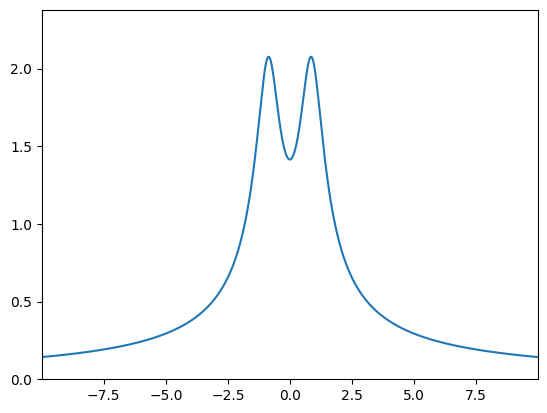

In [28]:
where = np.abs(x) < 10
anim = animate(np.abs(u[:,where]), t, x[where])
HTML(anim.to_jshtml())

# Checking Conservation Laws
## Mass :

  0%|          | 0/200 [00:00<?, ?it/s]

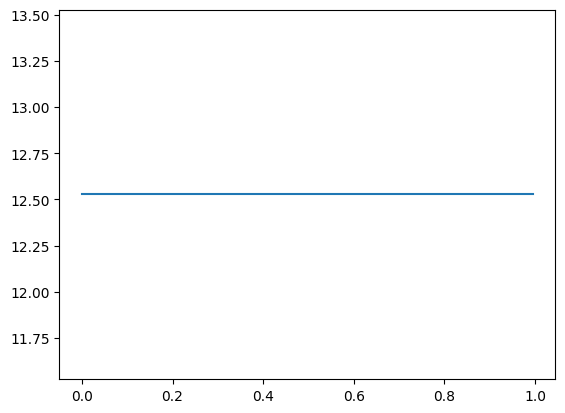

In [9]:
M = np.empty(shape = u.shape[0])
for i in tqdm(range(u.shape[0])):
    M[i] = mass(u[i],dx)
plt.ylim(M[0]-1,M[0]+1)
plt.plot(t,M)

## Energy :

  0%|          | 0/200 [00:00<?, ?it/s]

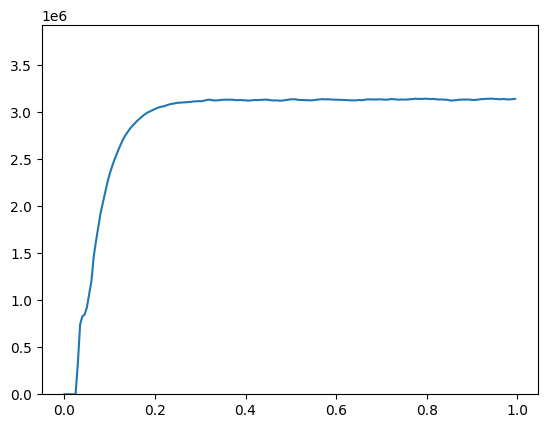

In [10]:
E = np.empty(shape=u.shape[0])
for i in tqdm(range(u.shape[0])):
    E[i] = energy(u[i], dx, xi)
plt.ylim(0,1.25*np.max(E))
plt.plot(t, E)